In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict as odict

Load the SN light curve fits that were generated in [this notebook](https://github.com/djreiss/AnalyzeSN/blob/master/notebooks/LC%20fitting%202.ipynb).

This is an array of "SN fit" objects. An example is printed at the end of this cell:

In [2]:
import gzip, cPickle
snFits = cPickle.load(gzip.GzipFile('snFits.p.gz'))
print len(snFits)
snf = [s for s in snFits.values() if s is not None]
print len(snf)
snf[0]

1622
1549


z                                                       0.991467
t0                                                       50889.3
x0                                                   1.86845e-06
x1                                                      -1.98289
c                                                       0.194243
hostebv                                                        0
hostr_v                                                      3.1
mwebv                                                          0
mwr_v                                                        3.1
mu                                                       13.4396
mu_var                                                  0.452145
inputParams    {u't0': 50890.5, u'x0': 1.28059e-06, u'x1': 0....
dtype: object

Use list comprehension to extract the redshift (`z`) and fitted distance modulus (`mu`) from each of the supernova light curve fits. Each of those becomes its own array of numbers.

Also extract `mu_var`. Need to do this in a loop since for some light curve fits `mu_var` doesn't exist (for a reason that I am not sure of right now).

In [3]:
z = np.array([s.z for s in snf])
mu = np.array([s.mu for s in snf])

mu_var = mu.copy() #np.array([s.mu_var for s in snf])
for i,s in enumerate(snf):
    try:
        mu_var[i] = s.mu_var
    except:
        mu_var[i] = 999

# Here, we didn't fit z so zz and z will be identical.
zz = z.copy() #np.array([s['inputParams'].get('z') for s in snf]) 
for i,s in enumerate(snf):
    try:
        zz[i] = s['inputParams'].get('z')
    except:
        zz[i] = 999

Filter the data to remove points that are probably way wrong (e.g. too high or too low `mu`).

TODO: we need to look at some of these bad points and understand why their fits gave incorrect results.

In [4]:
z = z[(mu > 0) & (mu < 19)]
zz = zz[(mu > 0) & (mu < 19)]
mu = mu[(mu > 0) & (mu < 19)]
mu_var = mu_var[(mu > 0) & (mu < 19)]

/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipyk

Plot the Hubble diagram.

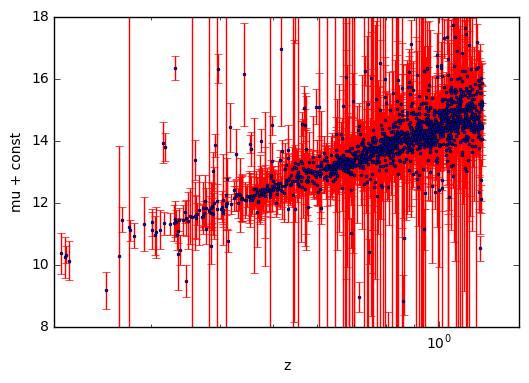

In [5]:
#plt.scatter(z, mu)
plt.errorbar(z, mu, yerr=np.sqrt(mu_var), fmt='o', ecolor='r', elinewidth=1, ms=2)
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('mu + const')
plt.xlim((0.2,1.4))
plt.ylim((8,18));

The `mu`s computed above are offset by some constant that we do not know yet. Let's estimate that offset by computing a Hubble diagram for a model cosmology.

In [6]:
from astropy.cosmology import Planck15 as cosmo
mu = np.array([s.mu for s in snf])
x0 = np.array([s.x0 for s in snf])
x0 = x0[(mu > 0) & (mu < 19)]
x1 = np.array([s.x1 for s in snf])
x1 = x1[(mu > 0) & (mu < 19)]
c = np.array([s.c for s in snf])
c = c[(mu > 0) & (mu < 19)]
mu = mu[(mu > 0) & (mu < 19)]
muz = np.array(cosmo.distmod(z))

alpha = 0.14
beta = -3.11
M = -2.5 * np.log10(x0) + alpha * x1 + beta * c - muz
# plt.scatter(z, muz)
# plt.xlabel('z')
# plt.xscale('log')
# plt.xlim((0.2,1.4))
# plt.ylabel('mu')
# plt.ylim((39,45));

/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:9

Compute the constant offset as the median of the differences between the cosmological `mu` and the fitted SN `mu`.

29.7558162588


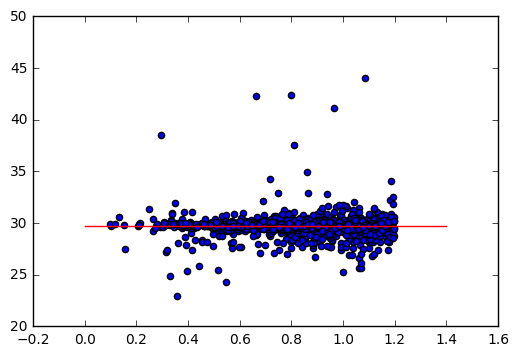

In [7]:
const = np.median(muz-mu)
print const
plt.scatter(z,muz-mu)
plt.plot([0,1.4],[const,const],'r')

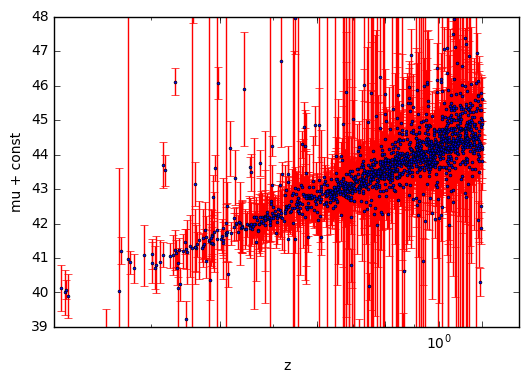

In [8]:
plt.errorbar(z, mu+const, yerr=np.sqrt(mu_var), fmt='o', ecolor='r', elinewidth=1, ms=2)
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('mu + const')
plt.xlim((0.2,1.4))
plt.xticks(np.arange(0.2,1.4,0.2))
plt.ylim((39,48));